# Quantum Simon's Algorithm

In [1]:
import pandas as pd
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram

## Basic assumptions:
- Bit indexing starts from the right side
- Qiskit has the least significant bit at the top which means it's the same indexing but from top to bottom

In [2]:
index = 452758
n_qubits = 3
trivial = "{0:b}".format(0).zfill(n_qubits)
secret = "{0:b}".format(index % (np.power(2, n_qubits))).zfill(n_qubits)
hidden_subgroup = [trivial, secret]

print('n-Qubits: {n}'.format(n = n_qubits))
print('Index: {index}'.format(index = index))
print('Index mod {mod}: {res}'.format(mod = np.power(2, n_qubits), res = index % (np.power(2, n_qubits))))
print('Secret: {secret}'.format(secret = secret))
print('Hidden subgroup: {{{hidden_subgroup}}} '.format(hidden_subgroup = ', '.join(hidden_subgroup)))

n-Qubits: 3
Index: 452758
Index mod 8: 6
Secret: 110
Hidden subgroup: {000, 110} 


## General creation of Simon oracle for n qubits

In [11]:
# customizable oracle function
def draw_simon_oracle(circ, secret, n_qubits = 3):
    # copy input to output cubits
    for i in range(n_qubits):
        circ.cx(i, n_qubits + i)

    # apply two-to-one mapping

    # check if it's not trivial with zeros only 
    if "1" in secret:
        secret = secret[::-1]
        # find the least index j in secret where the value is 1
        j = secret.find("1")

        # XOR output register with input when there is 1 starting from j index
        for i in range(j, len(secret)):
            if secret[j] == "1":
                circ.cx(j, n_qubits + i)

## Pre-processing

#### XOR helper function

In [4]:
def xor(x, y):
    res = ''
    for i in range(len(x)):
        if x[i] == y[i]:
            res += '0'
        else:
            res += '1'

    return res

#### Manual oracle helper function

In [6]:
def oracle_function(x, secret):
    x = x[::-1]
    res = ''
    if "1" in secret:
        secret = secret[::-1]
        # find the least index j in secret where the value is 1
        j = secret.find("1")

        # simulate behaviour of quantum oracle to get output values
        for i in range(0, len(secret)):
            if i >= j and secret[i] == "1":
                if x[j] == x[i]:
                    res += '0'
                else:
                    res += x[i]
            else:
                res += x[i]
    return res

#### Describe group

In [7]:
group_df = pd.DataFrame()
group_elements = ["{0:b}".format(x).zfill(n_qubits) for x in range(2**n_qubits)]
group_df['element'] = group_elements
display(group_df)

,element
0,000
1,001
2,010
3,011
4,100
5,101
6,110
7,111


#### Extract left-side layers
Performs g + H = {g + h : h in H} and prints out all left-side layers

In [8]:
# set in order to maintain uniqness of layers
leftside_layers = set()

for element in group_elements:
    xored = [xor(element, sub_element) for sub_element in hidden_subgroup]
    # sort elements inside layer
    xored.sort()
    xored = tuple(xored)
    leftside_layers.add(xored)

# sort all layers by it's first element for better readability
leftside_layers = list(leftside_layers)
leftside_layers.sort()

leftside_layers_df = pd.DataFrame()
leftside_layers_df['layers'] = list(leftside_layers)

display(leftside_layers_df)

,layers
0,"(000, 110)"
1,"(001, 111)"
2,"(010, 100)"
3,"(011, 101)"


#### Create two-to-one function

In [9]:
function_df = pd.DataFrame()

# possible inputs (group elements)
function_df['g'] = group_elements

# two-to-one function outputs
two_to_one_values = [oracle_function(x, secret) for x in group_elements]
function_df['f(g)'] = two_to_one_values

# assign same value to group elements with same two-to-one function value to emphasize the mapping
pair_symbols = function_df['f(g)'].apply(lambda x: int(x, 2))
function_df['pair_symbol'] = pair_symbols

# print out information about function result
inputs_size = len(group_elements)
outputs_size = len(set(pair_symbols))

print('Two-to-one function mapped {elements_number} possible inputs to {values_number} unique outputs.'.format(elements_number = inputs_size, values_number = outputs_size))
display(function_df)

Two-to-one function mapped 8 possible inputs to 4 unique outputs.


,g,f(g),pair_symbol
0,000,000,0
1,001,100,4
2,010,000,0
3,011,100,4
4,100,001,1
5,101,101,5
6,110,000,0
7,111,100,4


## Circuit creation

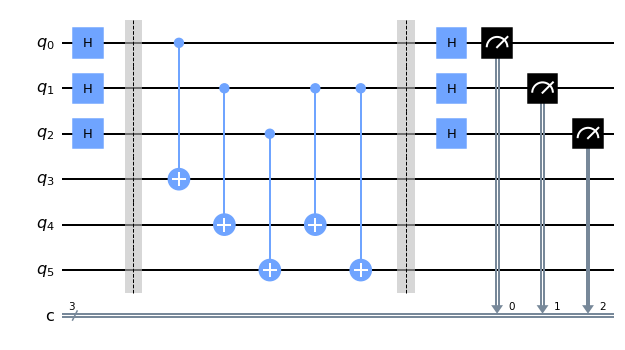

In [12]:
circ = QuantumCircuit(2 * n_qubits, n_qubits)

# QFT
for i in range(n_qubits):
    circ.h(i)

circ.barrier()

# add Simon oracle
draw_simon_oracle(circ, secret, n_qubits)

circ.barrier()

# IQFT
for i in range(n_qubits):
    circ.h(i)

# measures
for i in range(n_qubits):
    circ.measure(i, i)

# draw circuit
circ.draw('mpl')

## Shots - probabilities plot

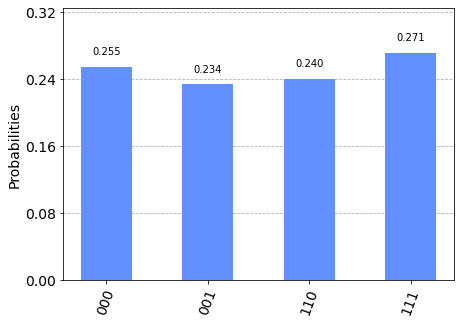

In [13]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(circ, shots = shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

## Collect the vectors

In [14]:
aer_sim = Aer.get_backend('aer_simulator')

v_set = set()

while len(v_set) < n_qubits:
    qobj = assemble(circ, shots = 1)
    results = aer_sim.run(qobj).result()
    v = list(results.get_counts().keys())[0]
    
    # don't add trivial result with zeros only
    if "1" in v:
        v_set.add(v)

i = 0
v_set = sorted(v_set)
for v in v_set:
    print('V{i}: [{values}]'.format(i = i, values = ' '.join(v)))
    i += 1

V0: [0 0 1]
V1: [1 1 0]
V2: [1 1 1]


## Extract system of the linear equations (mod 2)

In [20]:
import string

def get_linear_equations_system(v_mat, skip_coefficients = False):
    res = ''
    for equation in v_mat:
        eq = ''
        i = 0
        for coefficient in equation:
            if skip_coefficients:
                if coefficient == 1:
                    element = '{variable} + '.format(variable = string.ascii_lowercase[i])
                else:
                    i += 1
                    continue
            else:
                element = '{value} * {variable} + '.format(value = coefficient, variable = string.ascii_lowercase[i])
            eq += element
            i += 1
        eq = eq.rstrip('+ ')
        eq += ' = 0'
        res += eq
        res += '\n'
    
    res.rstrip('\n')
    return res

In [21]:
a = []

# v_set stores unique results of running circuit as binary strings for example: {"000", "001" ... }, each item has to be converted to an array
for v in v_set:
    # cast to int as the 0/1 in v are characters
    a.append([int(x) for x in v])

a = np.array(a)

print("Variables:")
variables = ', '.join(string.ascii_lowercase[:n_qubits])
print(variables)
print()

print("System of the linear equations:")
system_with_coefficients = get_linear_equations_system(a, skip_coefficients = False)
print(system_with_coefficients)
print()

print("Reduced system of the linear equations:")
system_reduced = get_linear_equations_system(a, skip_coefficients = True)
print(system_reduced)

Variables:
a, b, c

System of the linear equations:
0 * a + 0 * b + 1 * c = 0
1 * a + 1 * b + 0 * c = 0
1 * a + 1 * b + 1 * c = 0


Reduced system of the linear equations:
c = 0
a + b = 0
a + b + c = 0



#### Solving the system of linear equations leads to secret subgroup H.

## Solving the system of linear equations (mod 2) - requires Selenium with Chrome

1. Prepare your environment for Selenium with Chrome using this link: https://shanyitan.medium.com/how-to-install-selenium-and-run-it-successfully-via-jupyter-lab-c3f50d22a0d4
2. For solving system of linear equations you might also use this page (https://www.dcode.fr/modular-equation-solver) manually but automated == better :) 

In [17]:
from selenium.webdriver.common.by import By
from selenium import webdriver

In [27]:
modular_equation_solver_address = "https://www.dcode.fr/modular-equation-solver"

driver = webdriver.Chrome()
driver.get(modular_equation_solver_address)

# paths
modular_equation_solver_form_id = "modular_equation_solver"
modular_equation_solver_input_id = "modular_equation_solver_input"
modular_equation_solver_modulo_input_id = "modular_equation_solver_modulo"
modular_equation_solver_variables_input_id = "modular_equation_solver_variables"
modular_equation_solver_submit_button_xpath = "//button[@data-post='input,variables,modulo']"
agree_btn_class = "css-143z3ww"

# elements
modular_equation_solver_form = driver.find_element(By.ID, modular_equation_solver_form_id)
modular_equation_solver_input = driver.find_element(By.ID, modular_equation_solver_input_id)
modular_equation_solver_modulo_input = driver.find_element(By.ID, modular_equation_solver_modulo_input_id)
modular_equation_solver_variables_input = driver.find_element(By.ID, modular_equation_solver_variables_input_id)
modular_equation_solver_submit_button = driver.find_element(By.XPATH, modular_equation_solver_submit_button_xpath)
agree_btn = driver.find_element(By.CLASS_NAME, agree_btn_class)

# click on agree btn
agree_btn.click()

# clear input of equations
modular_equation_solver_input.clear()
# paste reduced system in input
modular_equation_solver_input.send_keys(system_reduced)

# clear input of modulo input
modular_equation_solver_modulo_input.clear()
# paste modulo 2 in input
modular_equation_solver_modulo_input.send_keys('2')

# clear input of variables input
modular_equation_solver_variables_input.clear()
# paste variables in input
modular_equation_solver_variables_input.send_keys(variables)

# submit form 
modular_equation_solver_submit_button.click()